<a href="https://colab.research.google.com/github/vasudevgupta7/cs4830-assignments/blob/main/lab-8/ME18B182_lab8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install Dependencies and Import Required Packages

In [1]:
# !sudo add-apt-repository ppa:openjdk-r/ppa
!sudo apt-get install openjdk-11-jdk
# To Install Oracke JDK varsion 8
# !sudo add-apt-repository ppa:webupd8team/java
# !sudo apt-get install oracle-java8-installer

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  openjdk-11-demo openjdk-11-source visualvm
The following NEW packages will be installed:
  openjdk-11-jdk
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 1,544 kB of archives.
After this operation, 1,595 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 openjdk-11-jdk amd64 11.0.14.1+1-0ubuntu1~18.04 [1,544 kB]
Fetched 1,544 kB in 0s (3,206 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 

In [2]:
# !wget -q https://downloads.apache.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
# !tar xvzf spark-3.1.1-bin-hadoop3.2.tgz
!pip install pyspark
!pip install -q findspark
!pip install pyarrow
try:
  # %tensorflow_version only exists in Colab.
  !pip install  tf-estimator-nightly==2.8.0.dev2021122109
except Exception:
  print("skipping tf-estimator-nightly==2.8.0.dev2021122109")
  pass

     |████████████████████████████████| 281.4 MB 33 kB/s 
     |████████████████████████████████| 198 kB 43.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=f586236c3ec993ca927e3944d8410610228162004b335629787724c86cc2b8f0
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark
     |████████████████████████████████| 462 kB 5.3 MB/s 


In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1"


In [4]:
from pyspark.sql.functions import col, pandas_udf, regexp_extract
import io

from tensorflow.keras.applications.imagenet_utils import decode_predictions
import pandas as pd
from pyspark.sql.functions import col, pandas_udf, PandasUDFType

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image

from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import pathlib
import findspark
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt 


findspark.init()
spark = SparkSession.builder.master("local[*]").getOrCreate()

Download the Public Dataset

In [5]:
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)

print(data_dir)

228827136/228813984 [==============================] - 3s 0us/step
/root/.keras/datasets/flower_photos


Recursively Read all the Images from the Parent directory and create a DataFrame

In [6]:
images = spark.read.format("binaryFile").option("recursiveFileLookup", "true").option("pathGlobFilter", "*.jpg").load(data_dir)
print(type(images))

<class 'pyspark.sql.dataframe.DataFrame'>


In [7]:
images.show(5)

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|file:/root/.keras...|2016-01-11 06:54:55|281953|[FF D8 FF E0 00 1...|
|file:/root/.keras...|2016-01-11 06:18:33|277326|[FF D8 FF E0 00 1...|
|file:/root/.keras...|2016-01-11 06:55:53|265806|[FF D8 FF E0 00 1...|
|file:/root/.keras...|2016-01-11 06:19:25|257418|[FF D8 FF E0 00 1...|
|file:/root/.keras...|2016-01-11 06:06:37|248540|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 5 rows



In [8]:
files=images.select('path').rdd.map(lambda x :x.path ).collect()
files[0:10]

['file:/root/.keras/datasets/flower_photos/tulips/2431737309_1468526f8b.jpg',
 'file:/root/.keras/datasets/flower_photos/sunflowers/4932735362_6e1017140f.jpg',
 'file:/root/.keras/datasets/flower_photos/tulips/8717900362_2aa508e9e5.jpg',
 'file:/root/.keras/datasets/flower_photos/sunflowers/4341530649_c17bbc5d01.jpg',
 'file:/root/.keras/datasets/flower_photos/daisy/5693459303_e61d9a9533.jpg',
 'file:/root/.keras/datasets/flower_photos/tulips/5674170543_73e3f403fb.jpg',
 'file:/root/.keras/datasets/flower_photos/tulips/10164073235_f29931d91e.jpg',
 'file:/root/.keras/datasets/flower_photos/sunflowers/6140892289_92805cc590.jpg',
 'file:/root/.keras/datasets/flower_photos/sunflowers/244074259_47ce6d3ef9.jpg',
 'file:/root/.keras/datasets/flower_photos/daisy/3704306975_75b74497d8.jpg']

In [9]:

def extract_label(path_col):
  """Extract label from file path using built-in SQL functions."""
  return regexp_extract(path_col, "flower_photos/([^/]+)", 1)

def extract_size(content):
  """Extract image size from its raw content."""
  image = Image.open(io.BytesIO(content))
  return image.size

@pandas_udf("width: int, height: int")
def extract_size_udf(content_series):
  sizes = content_series.apply(extract_size)
  return pd.DataFrame(list(sizes))

df = images.select(
  col("path"),
  col("modificationTime"),
  extract_label(col("path")).alias("label"),
  extract_size_udf(col("content")).alias("size"),
  col("content"))


df.show(5)


+--------------------+-------------------+----------+----------+--------------------+
|                path|   modificationTime|     label|      size|             content|
+--------------------+-------------------+----------+----------+--------------------+
|file:/root/.keras...|2016-01-11 06:54:55|    tulips|{500, 441}|[FF D8 FF E0 00 1...|
|file:/root/.keras...|2016-01-11 06:18:33|sunflowers|{500, 333}|[FF D8 FF E0 00 1...|
|file:/root/.keras...|2016-01-11 06:55:53|    tulips|{500, 333}|[FF D8 FF E0 00 1...|
|file:/root/.keras...|2016-01-11 06:19:25|sunflowers|{500, 290}|[FF D8 FF E0 00 1...|
|file:/root/.keras...|2016-01-11 06:06:37|     daisy|{500, 322}|[FF D8 FF E0 00 1...|
+--------------------+-------------------+----------+----------+--------------------+
only showing top 5 rows



In [10]:
ima=images.select('content').rdd.map(lambda x: x.content).collect()
ima[0]

bytearray(b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xe2\x0cXICC_PROFILE\x00\x01\x01\x00\x00\x0cHLino\x02\x10\x00\x00mntrRGB XYZ \x07\xce\x00\x02\x00\t\x00\x06\x001\x00\x00acspMSFT\x00\x00\x00\x00IEC sRGB\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf6\xd6\x00\x01\x00\x00\x00\x00\xd3-HP  \x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x11cprt\x00\x00\x01P\x00\x00\x003desc\x00\x00\x01\x84\x00\x00\x00lwtpt\x00\x00\x01\xf0\x00\x00\x00\x14bkpt\x00\x00\x02\x04\x00\x00\x00\x14rXYZ\x00\x00\x02\x18\x00\x00\x00\x14gXYZ\x00\x00\x02,\x00\x00\x00\x14bXYZ\x00\x00\x02@\x00\x00\x00\x14dmnd\x00\x00\x02T\x00\x00\x00pdmdd\x00\x00\x02\xc4\x00\x00\x00\x88vued\x00\x00\x03L\x00\x00\x00\x86view\x00\x00\x03\xd4\x00\x00\x00$lumi\x00\x00\x03\xf8\x00\x00\x00\x14meas\x00\x00\x04\x0c\x00\x00\x00$tech\x00\x00\x040\x00\x00\x00\x0crTRC\x00\x

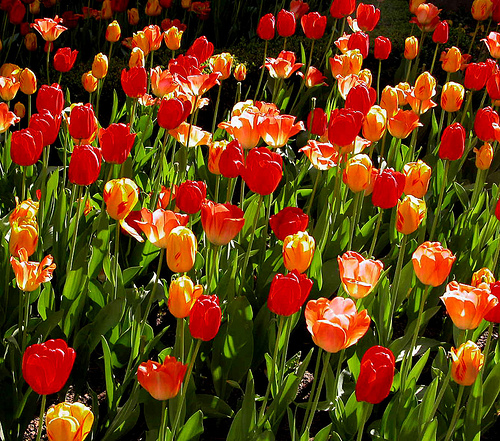

In [11]:
imgg = Image.open(io.BytesIO(ima[0]))
imgg

In [12]:
len(ima)

3670

In [13]:
class ImageNetDataset(Dataset):
  """
  Converts image contents into a PyTorch Dataset with standard ImageNet preprocessing.
  """
  def __init__(self, contents):
    self.contents = contents

  def __len__(self):
    
    return len(self.contents)

  def __getitem__(self, index):
    return self._preprocess(self.contents[index])

  def _preprocess(self, content):
    """
    Preprocesses the input image content using standard ImageNet normalization.
    
    See https://pytorch.org/docs/stable/torchvision/models.html.
    """
    image = Image.open(io.BytesIO(content))
    transform = transforms.Compose([
      transforms.Resize(256),                         ### Smaller lenght is convertd to 256 
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform(image)

In [14]:

def imagenet_model_udf():
  """
  Wraps an ImageNet model into a Pandas UDF that makes predictions.
  
  You might consider the following customizations for your own use case:
    - Tune DataLoader's batch_size and num_workers for better performance.
    - Use GPU for acceleration.
    - Change prediction types.
  """

  model=models.mobilenet_v2(pretrained=True)
  model.eval()
  def predict(content_series_iter : pd.Series) -> pd.DataFrame:
    # model = model_fn() # Once per Map
    # model.eval()      # Once Per Map ,model file read from memory
    for content_series in content_series_iter:                                                    #Iterates overall all Images 
      dataset = ImageNetDataset(list(content_series))                                           
      loader = DataLoader(dataset, batch_size=64) 
      with torch.no_grad():
        for image_batch in loader:
          predictions = model(image_batch).numpy()                                                # Predictions for all 1000 classes of Mobilenetv2 Training Dataset
          predicted_labels = [x[0] for x in decode_predictions(predictions, top=1)]                       
          yield pd.DataFrame(predicted_labels)


  return_type = "class: string, desc: string, score:float"
  # return_type = "class: string"                                         # SCALAR_ITER implies the function accepts list/array of scalar values as input.
  return pandas_udf(predict,return_type, PandasUDFType.SCALAR_ITER)   
  # return pandas_udf(return_type, PandasUDFType.SCALAR_ITER)(predict)   
  
  #Returns a Predict function object as the final user defined function object.
  #Iterates over an Image: A sequence of bytes represented as a 2D array. 
  #Scalar is a series of bytes.    

In [15]:
# imagenet = imagenet_model_udf(lambda: models.mobilenet_v2(pretrained=True))
imagenet = imagenet_model_udf()
imagenet

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/pyspark/sql/pandas/functions.py:392: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  "in the future releases. See SPARK-28264 for more details.", UserWarning)


<function __main__.imagenet_model_udf.<locals>.predict>

In [16]:
predictions = df.withColumn("prediction", imagenet(col("content")))
display(predictions.select(col("path"), col("prediction")).limit(5))

DataFrame[path: string, prediction: struct<class:string,desc:string,score:float>]

In [18]:
predictions.select(col("label"),col("prediction")).show(50,truncate=False)

+----------+-------------------------------------+
|label     |prediction                           |
+----------+-------------------------------------+
|tulips    |{n11939491, daisy, 11.117098}        |
|sunflowers|{n11939491, daisy, 12.223419}        |
|tulips    |{n03028079, church, 11.439265}       |
|sunflowers|{n03733281, maze, 8.724674}          |
|daisy     |{n03134739, croquet_ball, 9.196869}  |
|tulips    |{n11939491, daisy, 16.225416}        |
|tulips    |{n12620546, hip, 12.406092}          |
|sunflowers|{n11879895, rapeseed, 19.761276}     |
|sunflowers|{n11939491, daisy, 14.837954}        |
|daisy     |{n11939491, daisy, 22.246994}        |
|tulips    |{n03891251, park_bench, 11.074239}   |
|sunflowers|{n11879895, rapeseed, 20.18679}      |
|tulips    |{n04599235, wool, 7.8524837}         |
|tulips    |{n03457902, greenhouse, 10.672835}   |
|sunflowers|{n12144580, corn, 14.025856}         |
|tulips    |{n02782093, balloon, 12.340003}      |
|roses     |{n03991062, pot, 11